In [203]:
import psycopg2
import pandas as pd
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt
import xlrd
import datetime

In [207]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [213]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [7]:
vzw = pd.read_excel('Device List.xls', 'Verizon')
att = pd.read_excel('Device List.xls', 'AT&T')
crk = pd.read_excel('Device List.xls', 'Cricket')
amx = pd.read_excel('Device List.xls', 'AMX')
trf = pd.read_excel('Device List.xls', 'Tracfone')
usc = pd.read_excel('Device List.xls', 'US Cellular')
vzw['ELI'] = 'Verizon'
att['ELI'] = 'ATT'
crk['ELI'] = 'Cricket'
amx['ELI'] = 'AMXAPK'
trf['ELI'] = 'Tracfone'
usc['ELI'] = 'USCellular'
sheet_list = [crk,vzw,att,amx,trf,usc]
for s in sheet_list:
    s.columns = s.columns.str.replace('Sponsored Slots','# of Sponsored Slots')
    s.columns = s.columns.str.replace('# of # of','# of')
    s.columns = s.columns.str.replace('Games Launcher ONLY ON 6.0+','Games Launcher', regex=False)
    s['Total Slots'] = pd.to_numeric(s['Total Slots'], errors='coerce',downcast = 'float')
    s['# of Sponsored Slots'] = pd.to_numeric(s['# of Sponsored Slots'], errors='coerce',downcast = 'float')
    s['# of House Apps'] = pd.to_numeric(s['# of House Apps'], errors='coerce',downcast = 'float')
device_slots = pd.concat(sheet_list, join = 'outer')
device_slots.dtypes

ELI                      object
Manufacturer             object
Device Code Name         object
Model #                  object
Device Market Name       object
Silent Site ID            int64
Games Site ID            object
Tablet?                  object
Prepaid/PostPaid         object
Tier                     object
Total Slots             float32
# of Sponsored Slots    float32
# of Tracker Apps        object
Tracker Apps             object
Games Launcher           object
# of House Apps         float32
Unnamed: 16              object
For Automation           object
OS Ceiling              float64
AppList Site ID         float64
House Apps               object
Slot increase           float64
dtype: object

In [8]:
silent_sites = device_slots[['ELI','Silent Site ID', 'Total Slots', '# of Sponsored Slots', '# of House Apps']]
applist_sites = device_slots[['ELI','AppList Site ID','Total Slots','# of Sponsored Slots','# of House Apps']]
games_sites = device_slots[['ELI','Games Site ID','Total Slots','# of Sponsored Slots','# of House Apps']]

silent_sites.columns = ['c_name','site_id','all_config_slots','sponsored_config_slots','house_config_slots']
applist_sites.columns = ['c_name','site_id','all_config_slots','sponsored_config_slots','house_config_slots']
games_sites.columns = ['c_name','site_id','all_config_slots','sponsored_config_slots','house_config_slots']

device_slots_exploded = pd.concat([silent_sites,applist_sites,games_sites],join = 'outer')
device_slots_exploded

c_name  site_id  all_config_slots  sponsored_config_slots  \
0      Cricket     9179               8.0                     4.0   
1      Cricket     9184              18.0                    14.0   
2      Cricket     9285              19.0                    14.0   
3      Cricket     9356               8.0                     3.0   
4      Cricket     9373              19.0                    14.0   
..         ...      ...               ...                     ...   
95  USCellular  12586.0               NaN                    12.0   
96  USCellular  12588.0               NaN                    12.0   
97  USCellular  12590.0               NaN                    12.0   
98  USCellular  12592.0               NaN                    12.0   
99  USCellular  12594.0               NaN                    12.0   

    house_config_slots  
0                  4.0  
1                  4.0  
2                  4.0  
3                  4.0  
4                  4.0  
..                 ...  
95                 NaN  
96                 NaN  
97                 NaN  
98                 NaN  
99                 NaN  

[2082 rows x 5 columns]

In [9]:
device_slots_exploded[device_slots_exploded.c_name == 'Verizon'].site_id.head(30)

0     7317
1     7318
2     7319
3     7320
4     7374
5     7375
6     7682
7     7737
8     7966
9     8183
10    8184
11    8277
12    8278
13    8470
14    8675
15    8900
16    8902
17    9260
18    9261
19    9359
20    9360
21    9361
22    9520
23    9539
24    9584
25    9620
26    9621
27    9622
28    9628
29    9640
Name: site_id, dtype: object

In [10]:
query_preload = """
select
    t1.date_utc
    , t1.date_est
    , t1.siteid
    , t1.site_name
    , t1.isfdr
    , t1.c_name 
    , sum(t1.device_count) as device_count
    , sum(t2.all_preloads) as all_preloads
    , sum(t2.house_preloads) as house_preloads
    , sum(t2.sponsored_preloads) as sponsored_preloads
from
(
    select
        f.c_name
        , f.isfdr
        , date(f.createdate) as date_utc
        , date(f.createdate at time zone 'utc' at time zone 'est') as date_est 
        , f.siteid
        , max(f.site_name) as site_name
        , count(distinct imei) as device_count
    from rawdata.dt_device_report f
    join rawdata.site s
        on f.siteid = s.site_id
    where
        date(f.createdate) >= date('02-01-2021')
        and date(f.createdate at time zone 'utc' at time zone 'est') <= date('02-28-2021')
        and kind = 'production'
        and f.rs_carrier_id in (1,2,11,13,28,44)
        and s.site_name not like '%RDNS%'
        and f.processtypeid = 1
    group by 1,2,3,4,5
    having min(f.createdate) >= current_date-740
) t1 
left join
(
    select
        date(ctp.tracking_time at time zone 'est' at time zone 'utc') as date_utc
        , date(ctp.tracking_time) as date_est
        , case 
            when p.partner_name like '%America Movil%' then 'AMXAPK'
            else replace(replace(substring(p.partner_name,3),' ',''),'&','')
        end as c_name
        , ctp.site_id
        , case when ctp.placement_id = 99 then 1 else 0 end as isfdr
        , count(distinct referrer) as all_preloads
        , count(distinct case when settled_price_per_download = 0 then referrer else NULL end) as house_preloads
        , count(distinct case when settled_price_per_download > 0 then referrer else NULL end) as sponsored_preloads
    from rawdata.campaign_tracking_active_preload ctp
    join rawdata.site s
        on ctp.site_id = s.site_id
    join rawdata.partner_information p
        on s.partner_id = p.partner_id 
    where
        date(ctp.tracking_time) >= date('02-01-2021')
        and date(ctp.tracking_time) <= date('02-28-2021')
    group by 1,2,3,4,5
) t2 
    on t1.siteid = t2.site_id 
    and t1.date_utc = t2.date_utc
    and t1.date_est = t2.date_est 
    and t1.isfdr = t2.isfdr
    and t1.c_name = t2.c_name
group by 1,2,3,4,5,6
;
"""

In [11]:
query_spend = """
    select
        date(event_timestamp) as date_est
        , date(event_timestamp at time zone 'est' at time zone 'utc') as date_utc
        , f.site_id
        , case 
            when sd.partner_name like '%America Movil%' then 'AMXAPK'
            else replace(replace(substring(sd.partner_name,3),' ',''),'&','')
        end as c_name
        , case when placement_id = 99 then 1 else 0 end as isfdr
        , sum(gross_revenue) as revenue
    from venus.event_fact f
    join venus.site_dimension sd 
        on f.site_id = sd.site_id
    where
        date(f.event_timestamp) >= date('02-01-2021')
        and date(event_timestamp) <= current_date - interval '1' day 
    group by 1,2,3,4,5
"""

In [12]:
cur_olympus.execute(query_spend)
df_spend = pd.DataFrame(cur_olympus.fetchall(), columns = [c[0] for c in cur_olympus.description])
cur_atlas.execute(query_preload)
df_preload = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [13]:
df = pd.merge(df_spend, df_preload, left_on = ['date_est','date_utc','site_id','isfdr','c_name'], right_on = ['date_est','date_utc','siteid','isfdr','c_name'], how = 'left')
#df = pd.merge(df, device_slots_exploded, left_on = ['site_id','c_name'], right_on = ['site_id','c_name'])
df['revenue'] = df['revenue'].astype(float)
df = df[df.date_est != datetime.date.today()]
df[df.c_name=='CarrierUnallocated'].sort_values('revenue',ascending=False)

date_est    date_utc  site_id              c_name  isfdr  revenue  \
591    2021-02-03  2021-02-03    11002  CarrierUnallocated      0  4879.91   
20895  2021-02-05  2021-02-05    10023  CarrierUnallocated      0  4726.88   
69762  2021-03-03  2021-03-03    11002  CarrierUnallocated      0  4716.73   
30977  2021-02-06  2021-02-06    10023  CarrierUnallocated      0  4445.92   
13683  2021-02-07  2021-02-07    10023  CarrierUnallocated      0  4183.08   
...           ...         ...      ...                 ...    ...      ...   
35052  2021-02-14  2021-02-15     9502  CarrierUnallocated      0     0.00   
35059  2021-02-11  2021-02-12    11064  CarrierUnallocated      0     0.00   
36683  2021-02-16  2021-02-17     9502  CarrierUnallocated      0     0.00   
97321  2021-02-27  2021-02-28     9502  CarrierUnallocated      0     0.00   
23403  2021-02-05  2021-02-05    10895  CarrierUnallocated      0     0.00   

       siteid site_name  device_count  all_preloads  house_preloads  \
591       NaN       NaN           NaN           NaN             NaN   
20895     NaN       NaN           NaN           NaN             NaN   
69762     NaN       NaN           NaN           NaN             NaN   
30977     NaN       NaN           NaN           NaN             NaN   
13683     NaN       NaN           NaN           NaN             NaN   
...       ...       ...           ...           ...             ...   
35052     NaN       NaN           NaN           NaN             NaN   
35059     NaN       NaN           NaN           NaN             NaN   
36683     NaN       NaN           NaN           NaN             NaN   
97321     NaN       NaN           NaN           NaN             NaN   
23403     NaN       NaN           NaN           NaN             NaN   

       sponsored_preloads  
591                   NaN  
20895                 NaN  
69762                 NaN  
30977                 NaN  
13683                 NaN  
...                   ...  
35052                 NaN  
35059                 NaN  
36683                 NaN  
97321                 NaN  
23403                 NaN  

[1989 rows x 12 columns]

In [14]:
# combined fdr and non

c_name_list = ['Verizon','ATT','Cricket','AMXAPK','Tracfone','USCellular']
writer = pd.ExcelWriter('~/Downloads/Feb_slot_analysis.xlsx', engine='xlsxwriter')

for c_name in c_name_list:
    device_slots_filtered = device_slots_exploded.loc[device_slots_exploded.c_name == c_name,['site_id','all_config_slots','sponsored_config_slots','house_config_slots']]
    pivot = df[df.c_name == c_name].pivot_table(values = ['revenue',  'device_count', 'all_preloads', 'house_preloads', 'sponsored_preloads']
                             , index = ['site_id','site_name','date_est']
                             , aggfunc = np.sum)
    pivot = pd.merge(pivot.reset_index(),device_slots_filtered, left_on = 'site_id', right_on = 'site_id', how = 'left')
    pivot['all_slots_filled'] = round(pivot['all_preloads']/pivot['device_count'],1)
    pivot['sponsored_slots_filled'] = round(pivot['sponsored_preloads']/pivot['device_count'],1)
    pivot['house_slots_filled'] = round(pivot['house_preloads']/pivot['device_count'],1)
    pivot['all_rps'] = round(pivot['revenue']/pivot['all_preloads'],2)
    pivot['sponsored_rps'] = round(pivot['revenue']/pivot['sponsored_preloads'],2)
    pivot['rpd'] = round(pivot['revenue']/pivot['device_count'],2)
    pivot['sponsored_fill_rate'] = round(pivot['sponsored_preloads']/pivot['device_count']/pivot['sponsored_config_slots'],2)
    pivot = pivot.merge(pivot.groupby('site_id')['sponsored_preloads'].sum(), suffixes = ('','_site'), left_on = 'site_id', right_index=True)
    pivot = pivot[['site_id','site_name','date_est','revenue', 'device_count', 'rpd', 'all_config_slots', 'all_preloads', 'all_slots_filled', 'all_rps', 'sponsored_config_slots', 'sponsored_preloads', 'sponsored_slots_filled', 'sponsored_fill_rate', 'sponsored_preloads_site', 'sponsored_rps', 'house_config_slots', 'house_preloads', 'house_slots_filled']]
    pivot.sort_values(['sponsored_preloads_site','date_est'],ascending=[False,True],inplace=True)
    pivot.to_excel(writer, sheet_name = c_name, index = False)
writer.save()


In [15]:
# break out fdr
writer = pd.ExcelWriter('~/Downloads/Feb_slot_fdr_analysis.xlsx', engine='xlsxwriter')

for c_name in c_name_list:
    device_slots_filtered = device_slots_exploded.loc[device_slots_exploded.c_name == c_name,['site_id','all_config_slots','sponsored_config_slots','house_config_slots']]
    pivot = df[df.c_name == c_name].pivot_table(values = ['revenue',  'device_count', 'all_preloads', 'house_preloads', 'sponsored_preloads']
                             , index = ['site_id','site_name','date_est','isfdr']
                             , aggfunc = np.sum)
    pivot = pd.merge(pivot.reset_index(),device_slots_filtered, left_on = 'site_id', right_on = 'site_id', how = 'left')
    pivot['all_slots_filled'] = round(pivot['all_preloads']/pivot['device_count'],1)
    pivot['sponsored_slots_filled'] = round(pivot['sponsored_preloads']/pivot['device_count'],1)
    pivot['house_slots_filled'] = round(pivot['house_preloads']/pivot['device_count'],1)
    pivot['all_rps'] = round(pivot['revenue']/pivot['all_preloads'],2)
    pivot['sponsored_rps'] = round(pivot['revenue']/pivot['sponsored_preloads'],2)
    pivot['rpd'] = round(pivot['revenue']/pivot['device_count'],2)
    pivot['sponsored_fill_rate'] = round(pivot['sponsored_preloads']/pivot['device_count']/pivot['sponsored_config_slots'],2)
    pivot = pivot.merge(pivot.groupby(['isfdr','site_id'])['sponsored_preloads'].sum(), suffixes = ('','_site'), left_on = ['isfdr','site_id'], right_index=True)
    pivot = pivot[['site_id','site_name','isfdr','date_est','revenue', 'device_count', 'rpd', 'all_config_slots', 'all_preloads', 'all_slots_filled', 'all_rps', 'sponsored_config_slots', 'sponsored_preloads', 'sponsored_slots_filled', 'sponsored_fill_rate', 'sponsored_preloads_site', 'sponsored_rps', 'house_config_slots', 'house_preloads', 'house_slots_filled']]
    pivot.sort_values(['sponsored_preloads_site','date_est'],ascending=[False,True],inplace=True)
    pivot.to_excel(writer, sheet_name = c_name, index = False)
writer.save()

## Why is there a boost in verizon preloads from 2/1-3?

In [16]:
query_vzw = """
    select
        date(ctp.tracking_time) as date_utc
        , case when date(ctp.tracking_time) <= date('02-04-2021') then 0 else 1 end as week_part
        , ctp.site_id
        , ctp.ppd_campaign_action_type_id
        , c.campaign_name
        , c.house_ad
        , c.campaign_type_id
        , c.campaign_spot_id
        , c.app_id
        , c.test_campaign
        , ctp.device_id
        , ctp.language
        , ctp.countrycode
        , ctp.ppd_ad_type_id
        , ctp.ppd_campaign_creative_id
        , ctp.placement_id
        , ctp.template_id
        , ctp.error_code
        , ctp.algorithm_id
        , ctp.handset_id
        , ctp.retargeted
        , ctp.billing_type
        , ctp.location_id
        , ctp.country_code
        , ctp.metro_code
        , ctp.city
        , ctp.homescreen
        , ctp.budget_pool_id
        , ctp.sti_type
        , ctp.pia_revenue_setting_via
        , ctp.mmppartner
        , ctp.useinstallerbroadcast
        , ctp.reclickattribution
        , ctp.flows
        , count(distinct referrer) as preloads
    from rawdata.campaign_tracking_active_preload ctp
    join rawdata.campaign c 
        on c.campaign_id = ctp.campaign_id
    join rawdata.site s
        on ctp.site_id = s.site_id
    join rawdata.partner_information p
        on s.partner_id = p.partner_id 
        and p.partner_name like '%Verizon%'
    where
        date(ctp.tracking_time) >= date('02-01-2021')
        and date(ctp.tracking_time) <= date('02-8-2021')
    group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,19,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
;
"""

In [17]:
cur_atlas.execute(query_vzw)
df_vzw = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [18]:
df_vzw[df_vzw.site_id == 9371]

Empty DataFrame
Columns: [date_utc, week_part, site_id, ppd_campaign_action_type_id, campaign_name, house_ad, campaign_type_id, campaign_spot_id, app_id, test_campaign, device_id, language, countrycode, ppd_ad_type_id, ppd_campaign_creative_id, placement_id, template_id, error_code, algorithm_id, handset_id, retargeted, billing_type, location_id, country_code, metro_code, city, homescreen, budget_pool_id, sti_type, pia_revenue_setting_via, mmppartner, useinstallerbroadcast, reclickattribution, flows, preloads]
Index: []

[0 rows x 35 columns]

In [19]:
attr_list = ['site_id', 'house_ad', 'campaign_type_id', 'campaign_name', 'test_campaign', 'location_id','budget_pool_id','pia_revenue_setting_via']
for attr in attr_list:
    pivot = df_vzw.pivot_table(values = 'preloads',index = attr, columns = 'week_part', aggfunc = np.sum)
    pivot['delta'] = pivot[1]/pivot[0] - 1
    pivot['preload_change'] = pivot[1]-pivot[0]
    pivot['change_sov'] = (pivot[1] - pivot[0])/(pivot[1].sum() - pivot[0].sum())
    print(pivot.sort_values('preload_change').head(10))

week_part         0         1     delta  preload_change  change_sov
site_id                                                            
11037      172803.0   18433.0 -0.893329       -154370.0    0.089078
10924       97799.0    6214.0 -0.936462        -91585.0    0.052849
11870      188433.0   97737.0 -0.481317        -90696.0    0.052336
11274      141836.0   58744.0 -0.585832        -83092.0    0.047948
12254      155960.0   76890.0 -0.506989        -79070.0    0.045627
11977       95575.0   19345.0 -0.797594        -76230.0    0.043988
11275      126979.0   64818.0 -0.489538        -62161.0    0.035870
11917      107079.0   45446.0 -0.575584        -61633.0    0.035565
11909      182501.0  127950.0 -0.298908        -54551.0    0.031478
11403       80508.0   28502.0 -0.645973        -52006.0    0.030010
week_part        0        1     delta  preload_change  change_sov
house_ad                                                         
False      2617376  1638291 -0.374071         -97908

In [20]:
query_location = """
    select *
    from rawdata.location
    where id = 6252001
"""
cur_atlas.execute(query_location)
df_location = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
df_location

id country_iso_code   country_name subdivision_1_iso_code  \
0  6252001               US  United States                          

  subdivision_1_name subdivision_2_iso_code subdivision_2_name city_name  \
0                                                                          

  metro_code  
0       None

In [21]:
query_budget_pool = """
    select *
    from rawdata.campaign_budget_pool
    where id in (864,2776,2672,3060,1683,2646)
"""
cur_atlas.execute(query_budget_pool)
df_budget_pool = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
df_budget_pool

id  partner_id                            name  keep_alive
0   864        3166  Migrated active campaigns 3166       False
1  1683        4445       Pivot Mobile Budget Pools        True
2  2646        5075          Gram Games Budget Pool        True
3  2672        4592              TubiTV Budget Pool       False
4  2776        2076                King.com Open IO        True
5  3060        5353           Tripledot Budget Pool        True

In [22]:
a = 'budget_pool_id'
pivot = df_vzw.pivot_table(values = 'preloads', columns = 'date_utc', index = a, aggfunc = np.sum)
pd.merge(pivot.reset_index(),df_budget_pool, left_on = 'budget_pool_id', right_on = 'id', how = 'left').sort_values(pivot.columns[0],ascending=False).head(10)

budget_pool_id  2021-02-01  2021-02-02  2021-02-03  2021-02-04  \
0              864    391319.0    398091.0    558962.0    367221.0   
43            3672     87324.0     89944.0    121288.0     84376.0   
19            2776     69968.0     76310.0    103355.0     69149.0   
2             1683     52253.0     52733.0     70833.0     47407.0   
30            3060     51907.0     55303.0     96465.0     60151.0   
9             2293     50891.0     27216.0     10366.0      7630.0   
16            2646     45567.0     43757.0     59498.0     40402.0   
28            3030     38844.0     43837.0     61907.0     39095.0   
7             2282     36692.0     36491.0     38443.0     31465.0   
20            2781     24262.0     23346.0     33448.0     22514.0   

    2021-02-05  2021-02-06  2021-02-07  2021-02-08      id  partner_id  \
0     322048.0    293834.0    167438.0    253925.0   864.0      3166.0   
43     77090.0     67619.0     38944.0     62101.0     NaN         NaN   
19     59839.0     57640.0     32521.0     47587.0  2776.0      2076.0   
2      39966.0     36562.0     22041.0     32515.0  1683.0      4445.0   
30     41839.0     39030.0     21241.0     32172.0  3060.0      5353.0   
9      19342.0     15269.0     13243.0     10597.0     NaN         NaN   
16     29365.0     24473.0     16044.0     29048.0  2646.0      5075.0   
28     33086.0     31668.0     18341.0     27604.0     NaN         NaN   
7      24282.0     22165.0     13718.0     20726.0     NaN         NaN   
20     20388.0     17307.0     11771.0     16983.0     NaN         NaN   

                              name keep_alive  
0   Migrated active campaigns 3166      False  
43                             NaN        NaN  
19                King.com Open IO       True  
2        Pivot Mobile Budget Pools       True  
30           Tripledot Budget Pool       True  
9                              NaN        NaN  
16          Gram Games Budget Pool       True  
28                             NaN        NaN  
7                              NaN        NaN  
20                             NaN        NaN

In [23]:
a = 'flows'
pivot = df_vzw.pivot_table(values = 'preloads', columns = 'date_utc', index = a, aggfunc = np.sum)
pivot.sort_values(pivot.columns[0],ascending=False).head(10)

date_utc    2021-02-02  2021-02-03  2021-02-04  2021-02-05  2021-02-06  \
flows                                                                    
first_boot    823542.0   1400998.0    932356.0    793135.0    719862.0   
recovery       18985.0     24190.0     22928.0     26914.0     24726.0   
byod_swap       7009.0      8667.0      7746.0      7908.0      6733.0   
push               NaN         NaN         NaN         NaN         NaN   

date_utc    2021-02-07  2021-02-08  
flows                               
first_boot    425999.0    639324.0  
recovery       15504.0     20139.0  
byod_swap       4674.0      8027.0  
push               7.0        15.0

In [24]:
query_events = """
    select
        date(eventdate)
        , de.code
        , de.description
        , count(transactionid) as trans    
    from rawdata.dt_transactions_events t
    join rawdata.dt_events de
        on t.rs_carrier_id = de.rs_carrier_id 
        and t.eventid = de.eventid 
        and de.rs_carrier_Id = 1
    where
        t.rs_carrier_id = 1
        and date(eventdate) >= date('02-01-2021')
    group by 1,2,3
    order by trans desc 
"""
cur_atlas.execute(query_events)
df_trans_events = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

<AxesSubplot:xlabel='date'>

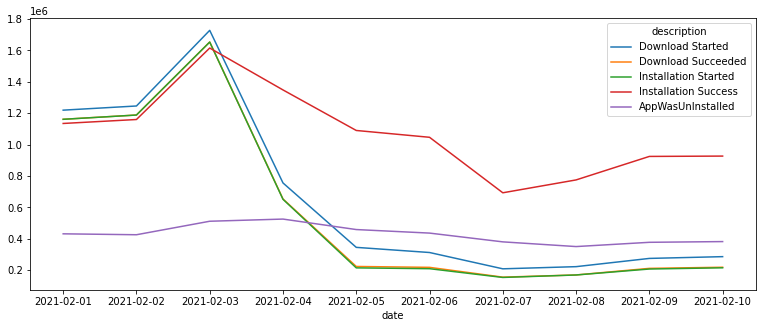

In [25]:
pivot = df_trans_events[df_trans_events.date <= datetime.date(2021,2,10)].pivot_table(values = 'trans', columns = 'description', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:5]].plot(figsize=(13,5))

Why does the number of installation Success exceed the number of installation start? 

In [26]:
query_trans = """
    select
        date(createdate)
        , apptypeid
        , carrierappid
        , versionid
        , networktypeid
        , configurednetworktypeid
        , isinstalled
        , count(transactionid) as trans    
    from rawdata.dt_transactions t
    where
        t.rs_carrier_id = 1
        and date(createdate) >= date('02-01-2021')
        and date(createdate) <= date('02-08-2021')
    group by 1,2,3,4,5,6,7
    order by trans desc 
"""
cur_atlas.execute(query_trans)
df_trans = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

<AxesSubplot:xlabel='date'>

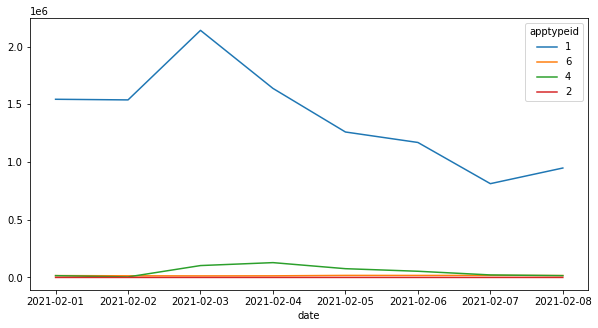

In [27]:
pivot = df_trans.pivot_table(values = 'trans', columns = 'apptypeid', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:5]].plot(figsize=(10,5))


<AxesSubplot:xlabel='date'>

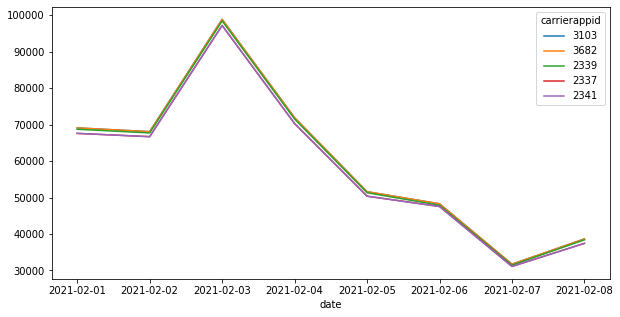

In [28]:
pivot = df_trans.pivot_table(values = 'trans', columns = 'carrierappid', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:5]].plot(figsize=(10,5))


<AxesSubplot:xlabel='date'>

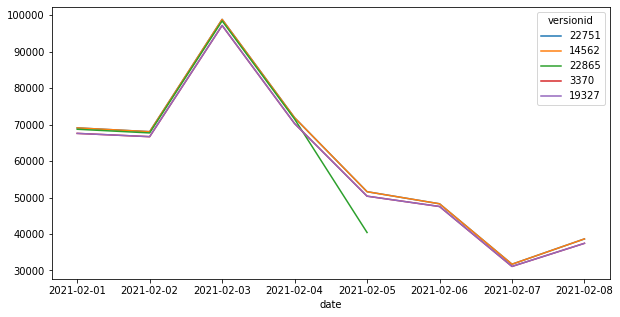

In [29]:
pivot = df_trans.pivot_table(values = 'trans', columns = 'versionid', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:5]].plot(figsize=(10,5))


<AxesSubplot:xlabel='date'>

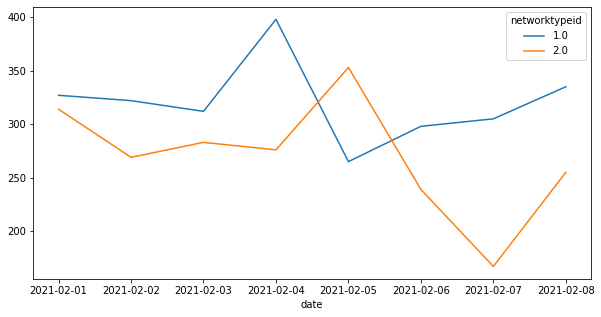

In [30]:
pivot = df_trans.pivot_table(values = 'trans', columns = 'networktypeid', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:5]].plot(figsize=(10,5))


<AxesSubplot:xlabel='date'>

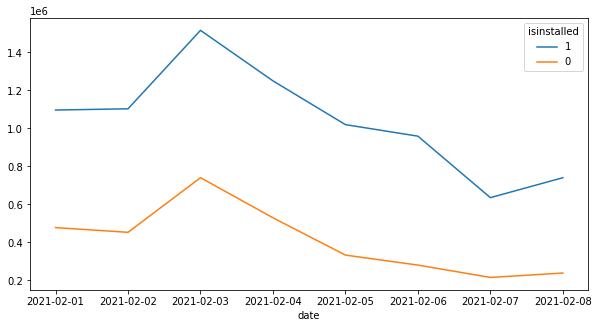

In [31]:
pivot = df_trans.pivot_table(values = 'trans', columns = 'isinstalled', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:5]].plot(figsize=(10,5))


In [32]:
query_process = """
    select
        date(startdate)
        , processtypename
        , carrierid
        , deviceosid
        , mccmnc
        , igniteversioncode
        , count(distinct processid) as processes
    from rawdata.dt_process t
    join rawdata.dt_process_type dp
        on t.processtypeid = dp.processtypeid
        and t.rs_carrier_id = dp.rs_carrier_id
        and dp.rs_carrier_id = 1
    where
        t.rs_carrier_id = 1
        and date(startdate) >= date('02-01-2021')
    group by 1,2,3,4,5,6
    order by processes desc 
"""
cur_atlas.execute(query_process)
df_process = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

<AxesSubplot:xlabel='date'>

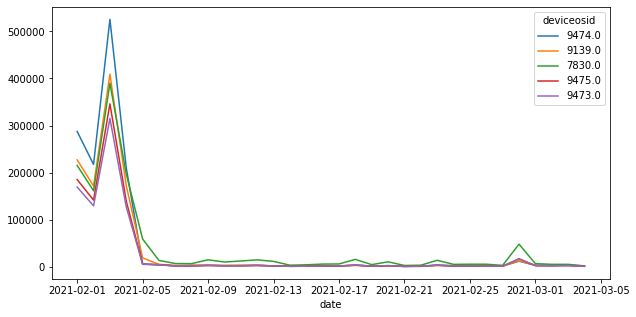

In [33]:
pivot = df_process.pivot_table(values = 'processes', columns = 'deviceosid', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:5]].plot(figsize=(10,5))


<AxesSubplot:xlabel='date'>

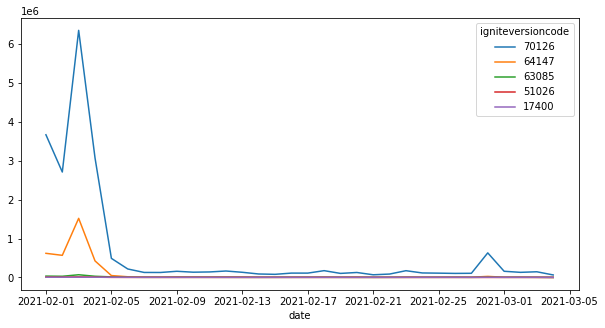

In [34]:
pivot = df_process.pivot_table(values = 'processes', columns = 'igniteversioncode', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:5]].plot(figsize=(10,5))


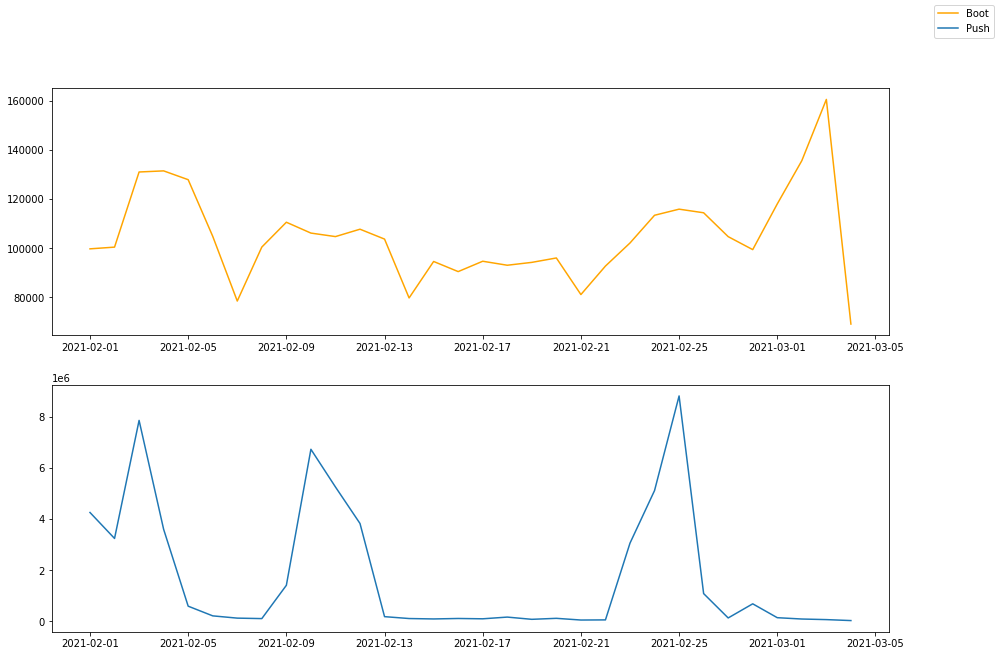

In [35]:
pivot = df_process.pivot_table(values = 'processes', columns = 'processtypename', index = 'date', aggfunc = 'sum')
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
fig, ax = plt.subplots(2,1, figsize = (15,10))
ax[0].plot(pivot[pivot.columns[1]],label = pivot.columns[1], color = 'orange')
ax[1].plot(pivot[pivot.columns[0]],label = pivot.columns[0])
fig.legend()

Nolan mentioned that there was a push that caused erroneous first boots to happen on pre-existing devices..

In [36]:
query_second_first_boot = """
    select
        date(p.startdate) as dt
        , processtypename
        , l.siteid
        , e.code
        , e.description
        , count(distinct p.processid) as processes
    from rawdata.dt_process p 
    join rawdata.dt_process_events pe 
        on pe.processid = p.processid 
        and pe.rs_carrier_id = p.rs_carrier_id 
        and pe.rs_carrier_id = 1
    join rawdata.dt_events e 
        on e.eventid = pe.eventid 
        and e.rs_carrier_id = p.rs_carrier_id 
        and e.rs_carrier_id = 1
    join rawdata.dt_ad_integration_error_log l 
        on l.processid = p.processid 
        and l.rs_carrier_id = p.rs_carrier_id 
        and l.rs_carrier_id = 1
    join
    (
        select
            date(startdate) as dt
            , f_sha256_salt(imei) as imei
        from rawdata.dt_process
        where rs_carrier_id = 1
        and date(startdate) >= date('10-01-2020')
        and processtypeid = 1
    ) fb
        on f_sha256_salt(p.imei) = fb.imei
    join rawdata.dt_process_type dp
        on p.processtypeid = dp.processtypeid
        and p.rs_carrier_id = dp.rs_carrier_id
        and dp.rs_carrier_id = 1
    where
        p.rs_carrier_id = 1
        and date(p.startdate) >= date('02-01-2021')
        and date(p.startdate) - fb.dt > 0
    group by 1,2,3,4,5
    order by processes desc 
"""
cur_atlas.execute(query_second_first_boot)
df_second_first_boot = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

<AxesSubplot:xlabel='dt'>

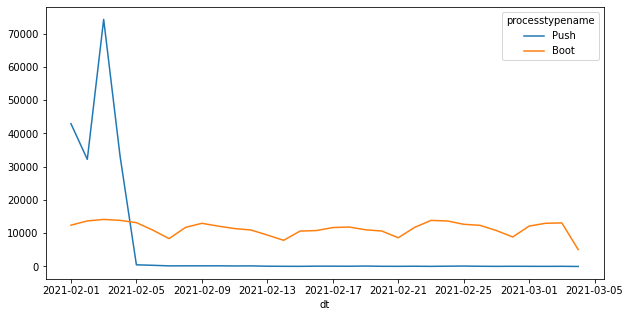

In [37]:
a = ['processtypename']
pivot = df_second_first_boot[df_second_first_boot.siteid.isin([11909, 11870, 12254, 11274, 11275, 12118, 12211, 11917, 11037, 11038, 12117, 11976, 11403])].pivot_table(values = 'processes', index = 'dt', columns = a, aggfunc = np.sum)
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:10]].plot(figsize = (10,5))

<AxesSubplot:xlabel='dt'>

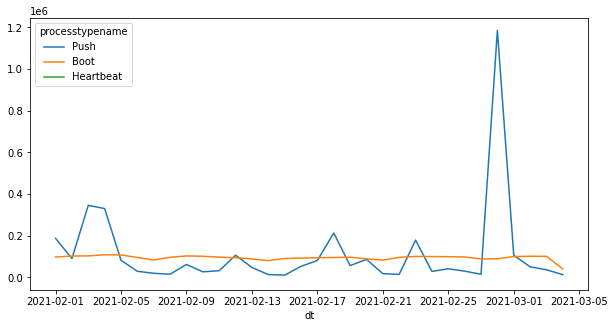

In [38]:
a = ['processtypename']
pivot = df_second_first_boot.pivot_table(values = 'processes', index = 'dt', columns = a, aggfunc = np.sum)
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:10]].plot(figsize = (10,5))

<AxesSubplot:xlabel='dt'>

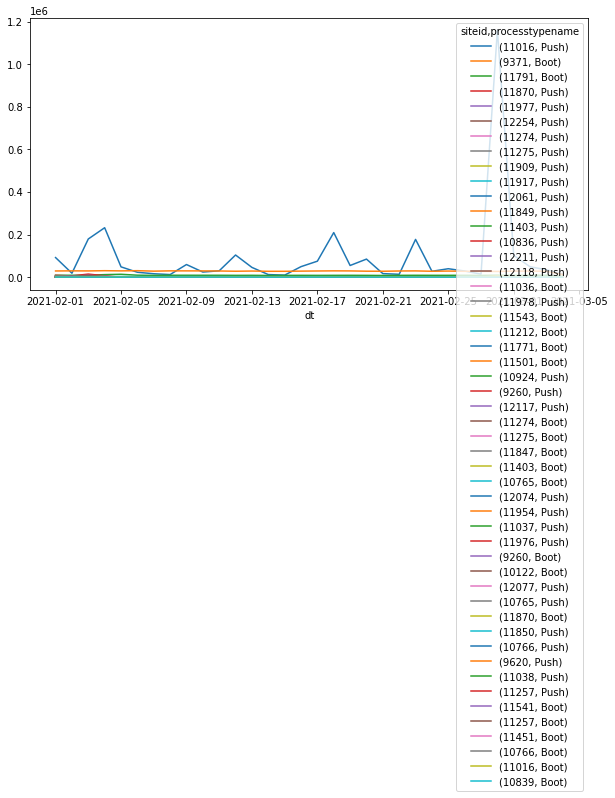

In [39]:
a = ['siteid','processtypename']
pivot = df_second_first_boot.pivot_table(values = 'processes', index = 'dt', columns = a, aggfunc = np.sum)
pivot.sort_values(pivot.index[0],axis=1,ascending=False,inplace=True)
pivot[pivot.columns[:50]].plot(figsize = (10,5))

In [40]:
pvt = df_second_first_boot.pivot_table(values = 'processes', index = 'siteid', columns = 'processtypename', aggfunc = np.sum)
pvt.sort_values(['Push','Boot'],ascending=False).head(30)
top_sites = pvt.loc[(pvt.Push * pvt.Boot).sort_values(ascending=False).index].head(10).index
top_sites
pvt

processtypename     Boot  Heartbeat    Push
siteid                                     
0                13295.0        NaN  1087.0
7317               614.0        NaN     NaN
7319              5795.0        NaN     NaN
7320               211.0        NaN     6.0
7374              3326.0        NaN    55.0
...                  ...        ...     ...
12560              535.0        NaN     NaN
12561              751.0        NaN     NaN
12563             1692.0        NaN    12.0
12564              779.0        NaN    26.0
12566             1095.0        NaN     NaN

[146 rows x 3 columns]

In [41]:
cur_atlas.execute(f"select site_name, site_id, partner_name from rawdata.site s join rawdata.partner_information p on s.partner_id = p.partner_id where site_id in ({','.join(str(x) for x in top_sites)}) group by 1,2,3")
pivot = pd.merge(pvt.reindex(),pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description]),left_on = 'siteid',right_on = 'site_id',how='left')
pivot.loc[(pivot.Push * pivot.Boot).sort_values(ascending=False).reindex().index].head(10)

Boot  Heartbeat       Push  \
60    52586.0        6.0  3066860.0   
22   913006.0        NaN    26393.0   
69    74009.0        NaN    94664.0   
94   293043.0        4.0    10656.0   
100   41925.0        NaN    37655.0   
72    49373.0        NaN    16694.0   
71    44305.0        NaN    18101.0   
101   36519.0        NaN    14497.0   
80    36873.0        NaN    13001.0   
107   19474.0        NaN    22734.0   

                                             site_name  site_id  \
60                       DT - DTOM - VZW - Ignite - SR  11016.0   
22         DT - DTOM - VZW - US - Ignite - All Devices   9371.0   
69                    DT - DTOM - VZW - Ignite - Games  11212.0   
94        DT - DTOM - VZW OM - US - Ignite - RDNS BYOD  11791.0   
100  DT - Verizon - US - Ignite - Samsung - A01 - S...  11870.0   
72   DT - Verizon - US - Ignite - Samsung - S10 - S...  11275.0   
71   DT - Verizon - US - Ignite - Samsung - S10E - ...  11274.0   
101  DT - Verizon - US - Ignite - Samsung - A51 - S...  11909.0   
80          DT - Verizon - US - Ignite - Motorola - Z4  11403.0   
107  DT - Verizon - US - Ignite - Samsung - A11 - S...  11977.0   

               partner_name  
60   DT Carrier Unallocated  
22   DT Carrier Unallocated  
69   DT Carrier Unallocated  
94   DT Carrier Unallocated  
100              DT Verizon  
72               DT Verizon  
71               DT Verizon  
101              DT Verizon  
80               DT Verizon  
107              DT Verizon

In [42]:
pivot.sum()

Boot         3026101.0
Heartbeat         10.0
Push         3616679.0
site_id       113098.0
dtype: float64

Looks like there were a lot of pushes, but not an increased number of boots on pre-booted devices. let's just see overall how many apps returned there were:

In [43]:
query_processes = """
    select
        date(p.startdate) as dt
        , processtypename
        , l.siteid
        , e.code
        , e.description
        , requestedslots
        , returnedslots
        , count(distinct p.processid) as processes
    from rawdata.dt_process p 
    join rawdata.dt_process_events pe 
        on pe.processid = p.processid 
        and pe.rs_carrier_id = p.rs_carrier_id 
        and pe.rs_carrier_id = 1
    join rawdata.dt_events e 
        on e.eventid = pe.eventid 
        and e.rs_carrier_id = p.rs_carrier_id 
        and e.rs_carrier_id = 1
    join rawdata.dt_ad_integration_error_log l 
        on l.processid = p.processid 
        and l.rs_carrier_id = p.rs_carrier_id 
        and l.rs_carrier_id = 1
    join rawdata.dt_process_type dp
        on p.processtypeid = dp.processtypeid
        and p.rs_carrier_id = dp.rs_carrier_id
        and dp.rs_carrier_id = 1
    where
        p.rs_carrier_id = 1
        and date(p.startdate) >= date('02-01-2021')
    group by 1,2,3,4,5,6,7
    order by processes desc 
"""
cur_atlas.execute(query_processes)
df_processes = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [44]:
df_processes['total_returned_slots'] = df_processes['processes']*df_processes['returnedslots']
df_processes.head(30)

dt processtypename  siteid  code                    description  \
0   2021-02-28            Push   11016   800  AdServerRespondedSuccessfully   
1   2021-02-28            Push   11016   630   Ignite Version Is Up To Date   
2   2021-02-28            Push   11016   720                NewPushArrivied   
3   2021-02-28            Push   11016   810  AdServerRespondedEmptyMessage   
4   2021-02-28            Push   11016   630   Ignite Version Is Up To Date   
5   2021-02-28            Push   11016   720                NewPushArrivied   
6   2021-02-04            Push   11016   800  AdServerRespondedSuccessfully   
7   2021-02-04            Push   11016   720                NewPushArrivied   
8   2021-02-04            Push   11016   630   Ignite Version Is Up To Date   
9   2021-02-03            Push   11016   800  AdServerRespondedSuccessfully   
10  2021-02-03            Push   11016   630   Ignite Version Is Up To Date   
11  2021-02-03            Push   11016   720                NewPushArrivied   
12  2021-02-18            Push   11016   720                NewPushArrivied   
13  2021-02-18            Push   11016   630   Ignite Version Is Up To Date   
14  2021-02-23            Push   11016   720                NewPushArrivied   
15  2021-02-23            Push   11016   630   Ignite Version Is Up To Date   
16  2021-02-18            Push   11016   800  AdServerRespondedSuccessfully   
17  2021-02-12            Push   11016   800  AdServerRespondedSuccessfully   
18  2021-02-12            Push   11016   720                NewPushArrivied   
19  2021-02-12            Push   11016   630   Ignite Version Is Up To Date   
20  2021-02-20            Push   11016   800  AdServerRespondedSuccessfully   
21  2021-02-20            Push   11016   720                NewPushArrivied   
22  2021-02-20            Push   11016   630   Ignite Version Is Up To Date   
23  2021-02-23            Push   11016   800  AdServerRespondedSuccessfully   
24  2021-02-09            Push   11016   800  AdServerRespondedSuccessfully   
25  2021-02-09            Push   11016   720                NewPushArrivied   
26  2021-02-09            Push   11016   630   Ignite Version Is Up To Date   
27  2021-02-13            Push   11016   720                NewPushArrivied   
28  2021-02-13            Push   11016   630   Ignite Version Is Up To Date   
29  2021-02-13            Push   11016   800  AdServerRespondedSuccessfully   

    requestedslots  returnedslots  processes  total_returned_slots  
0              1.0            1.0     378707              378707.0  
1              1.0            1.0     368571              368571.0  
2              1.0            1.0     360943              360943.0  
3              1.0            0.0     181961                   0.0  
4              1.0            0.0     174871                   0.0  
5              1.0            0.0     174817                   0.0  
6              1.0            1.0     121947              121947.0  
7              1.0            1.0     119827              119827.0  
8              1.0            1.0     117968              117968.0  
9              1.0            1.0     107230              107230.0  
10             1.0            1.0     103849              103849.0  
11             1.0            1.0     102993              102993.0  
12             1.0            1.0      85888               85888.0  
13             1.0            1.0      84588               84588.0  
14             1.0            1.0      77283               77283.0  
15             1.0            1.0      76696               76696.0  
16             1.0            1.0      62419               62419.0  
17             1.0            1.0      58848               58848.0  
18             1.0            1.0      58172               58172.0  
19             1.0            1.0      57851               57851.0  
20             1.0            1.0      51136               51136.0  
21             1.0            1.0      50749

<AxesSubplot:xlabel='dt'>

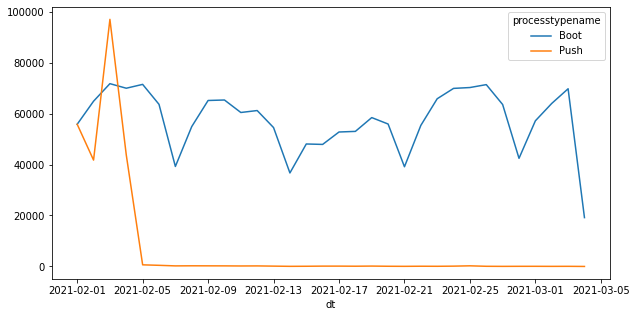

In [45]:
df_processes_filtered = df_processes.loc[(df_processes.siteid.isin([11909, 11870, 12254, 11274, 11275, 12118, 12211, 11917, 11037, 11038, 12117, 11976, 11403]))]
df_processes_filtered.pivot_table(values = 'processes', index = ['dt'], columns = 'processtypename', aggfunc = 'sum').plot(figsize=(10,5))


<AxesSubplot:xlabel='dt'>

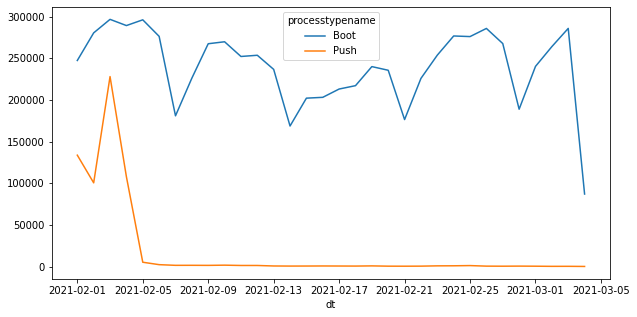

In [46]:
df_processes_filtered = df_processes.loc[(~df_processes.siteid.isin([9371,11016,11212,11791]))]
df_processes_filtered.pivot_table(values = 'processes', index = ['dt'], columns = 'processtypename', aggfunc = 'sum').plot(figsize=(10,5))


In [47]:
df_processes[df_processes.processtypename == 'Push'].pivot_table(values = 'processes',index = ['requestedslots','returnedslots'],aggfunc = np.sum).sort_values('processes',ascending=False).head(30)

processes
requestedslots returnedslots           
1.0            1.0              4055972
               0.0              1225239
20.0           20.0              339677
19.0           19.0              107963
17.0           17.0               88676
13.0           4.0                49559
               5.0                39118
21.0           21.0               28927
15.0           15.0               23474
13.0           6.0                17761
               3.0                15022
12.0           12.0                8322
16.0           16.0                8127
18.0           18.0                7508
13.0           13.0                5032
11.0           11.0                4963
15.0           13.0                3557
13.0           1.0                 3358
15.0           14.0                3119
13.0           2.0                 2988
               7.0                 2776
12.0           0.0                 2368
14.0           14.0                1831
13.0           0.0                 1786
12.0           1.0                 1225
15.0           12.0                1218
12.0           8.0                 1123
               7.0                  858
20.0           0.0                  786
12.0           6.0                  766

<AxesSubplot:xlabel='dt'>

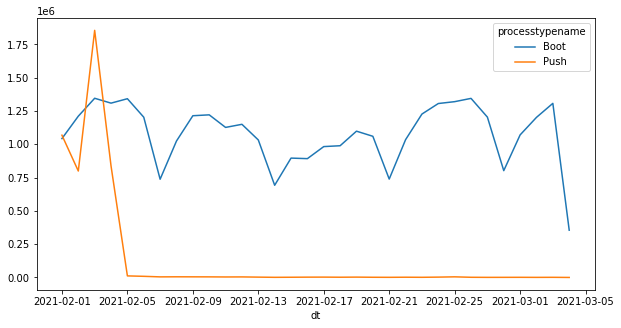

In [48]:
df_processes_filtered = df_processes.loc[(df_processes.siteid.isin([11909, 11870, 12254, 11274, 11275, 12118, 12211, 11917, 11037, 11038, 12117, 11976, 11403]))]
df_processes_filtered.pivot_table(values = 'total_returned_slots', index = ['dt'], columns = 'processtypename', aggfunc = np.sum).plot(figsize=(10,5))


In [49]:
df_processes_filtered = df_processes.loc[(df_processes.siteid.isin([11909, 11870, 12254, 11274, 11275, 12118, 12211, 11917, 11037, 11038, 12117, 11976, 11403]))]
df_processes_filtered.pivot_table(values = ['total_returned_slots','returnedslots','processes'], index = ['processtypename'], aggfunc = np.sum)

processes  returnedslots  total_returned_slots
processtypename                                                
Boot               1838565        80806.0            34475675.0
Push                242513        33188.0             4638310.0

<AxesSubplot:xlabel='dt'>

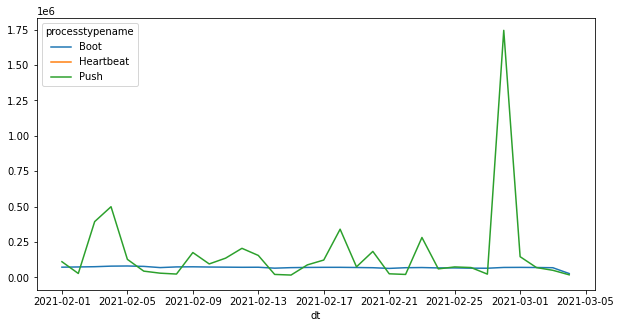

In [50]:
df_processes_filtered = df_processes.loc[(df_processes.siteid.isin([9371,11016,11212,11791]))]
df_processes_filtered.pivot_table(values = 'processes', index = ['dt'], columns = 'processtypename', aggfunc = 'sum').plot(figsize=(10,5))


In [51]:
query_low_fill_log = """
    select
        l.siteid
        , l.rs_carrier_id
        , l.eventid
        , de.code as event_code
        , de.description as event_name
        , dos.osname
        , p.igniteversioncode
        , p.igniteversionname
        , p.mccmnc
        , p.processtypeid
        , l.requestedslots
        , l.returnedslots
        , count(distinct p.processid) as calls
    from rawdata.dt_process p
    join rawdata.dt_ad_integration_error_log l
        on l.rs_carrier_id = p.rs_carrier_id
        and l.processid = p.processid
    join rawdata.dt_events de 
        on l.rs_carrier_id = de.rs_carrier_id
        and l.eventid = de.eventid
    join rawdata.dt_device_os dos 
        on dos.deviceosid = p.deviceosid
        and dos.rs_carrier_id = p.rs_carrier_id
    where
        date(createdate) >= date('02-01-2021')
    group by 
        l.siteid
        , l.rs_carrier_id
        , l.eventid
        , de.code 
        , de.description 
        , dos.osname
        , p.igniteversioncode
        , p.igniteversionname
        , p.mccmnc
        , p.processtypeid
        , l.requestedslots
        , l.returnedslots
"""
cur_atlas.execute(query_low_fill_log)
df_low_fill_log = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [52]:
df_low_fill_log['pct_filled'] = df_low_fill_log['returnedslots']/df_low_fill_log['requestedslots']

# Cricket drops

In [53]:
df_low_fill_log['cricket_drop'] = df_low_fill_log.siteid.isin([
    11918,11958,11920,10769,11190,11192,11348,10614,11408,10937,11180,10802,11184,11186,10096])
df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11)].corr()

siteid  rs_carrier_id   eventid  event_code  processtypeid  \
siteid          1.000000            NaN -0.065328    0.054582       0.003734   
rs_carrier_id        NaN            NaN       NaN         NaN            NaN   
eventid        -0.065328            NaN  1.000000    0.012592      -0.047476   
event_code      0.054582            NaN  0.012592    1.000000      -0.027062   
processtypeid   0.003734            NaN -0.047476   -0.027062       1.000000   
requestedslots  0.066041            NaN -0.054037    0.010057       0.037275   
returnedslots   0.080096            NaN -0.012030    0.027080      -0.032228   
calls           0.010279            NaN  0.003049   -0.026452       0.012143   
pct_filled      0.042586            NaN -0.014420   -0.045019      -0.046303   
cricket_drop    0.011185            NaN -0.036262   -0.010030      -0.125192   

                requestedslots  returnedslots     calls  pct_filled  \
siteid                0.066041       0.080096  0.010279    0.042586   
rs_carrier_id              NaN            NaN       NaN         NaN   
eventid              -0.054037      -0.012030  0.003049   -0.014420   
event_code            0.010057       0.027080 -0.026452   -0.045019   
processtypeid         0.037275      -0.032228  0.012143   -0.046303   
requestedslots        1.000000       0.628313  0.003105    0.064928   
returnedslots         0.628313       1.000000  0.032184    0.610358   
calls                 0.003105       0.032184  1.000000    0.034667   
pct_filled            0.064928       0.610358  0.034667    1.000000   
cricket_drop         -0.077995      -0.030064  0.007514   -0.098620   

                cricket_drop  
siteid              0.011185  
rs_carrier_id            NaN  
eventid            -0.036262  
event_code         -0.010030  
processtypeid      -0.125192  
requestedslots     -0.077995  
returnedslots      -0.030064  
calls               0.007514  
pct_filled         -0.098620  
cricket_drop        1.000000

In [54]:
i = 'event_name'

# Hardcoded list of longest/largest cricket drops
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (~df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False)


calls_ron  sov_ron  \
event_name                                                              
AdServerReturnedMissingPackageNames                   151726    0.040   
AdServerReturnedAResponse                            2883429    0.765   
AdServerReturnedDifferentSlotsNumberThanRequested     186587    0.050   
AdServerRespondedEmptyMessage                         507858    0.135   
Balalaika Error                                        37073    0.010   
AdServerRespondedErrorMessage                            430    0.000   

                                                   calls_selected  \
event_name                                                          
AdServerReturnedMissingPackageNames                         46312   
AdServerReturnedAResponse                                  335746   
AdServerReturnedDifferentSlotsNumberThanRequested            9468   
AdServerRespondedEmptyMessage                               67232   
Balalaika Error                                              1546   
AdServerRespondedErrorMessage                                  16   

                                                   sov_selected  sov_diff  
event_name                                                                 
AdServerReturnedMissingPackageNames                       0.101     0.061  
AdServerReturnedAResponse                                 0.729     0.036  
AdServerReturnedDifferentSlotsNumberThanRequested         0.021     0.029  
AdServerRespondedEmptyMessage                             0.146     0.011  
Balalaika Error                                           0.003     0.007  
AdServerRespondedErrorMessage                             0.000     0.000

In [55]:
i = 'processtypeid'

# Hardcoded list of longest/largest cricket drops
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (~df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot_ex
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False)

calls_ron  sov_ron  calls_selected  sov_selected  sov_diff
processtypeid                                                            
1                1929901    0.512        450905.0          0.98     0.468
2                1837201    0.488          9415.0          0.02     0.468
4                      1    0.000             NaN           NaN       NaN

In [56]:
i = 'requestedslots'

# Hardcoded list of longest/largest cricket drops
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (~df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot_ex
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False)

calls_ron  sov_ron  calls_selected  sov_selected  sov_diff
requestedslots                                                            
19.0               295859    0.079        182029.0         0.395     0.316
20.0               173083    0.046        141441.0         0.307     0.261
50.0               943655    0.252         10603.0         0.023     0.229
18.0                 6474    0.002         60317.0         0.131     0.129
3.0                 13726    0.004         49404.0         0.107     0.103
12.0               342722    0.092         16510.0         0.036     0.056
1.0               1134578    0.303             NaN           NaN       NaN
2.0                 17183    0.005             NaN           NaN       NaN
6.0                    46    0.000             NaN           NaN       NaN
7.0                 17520    0.005             NaN           NaN       NaN
8.0                 58426    0.016             NaN           NaN       NaN
9.0                 62024    0.017             NaN           NaN       NaN
10.0                42939    0.011             NaN           NaN       NaN
11.0               236645    0.063             NaN           NaN       NaN
13.0               124746    0.033             NaN           NaN       NaN
14.0                 9552    0.003             NaN           NaN       NaN
15.0                61046    0.016             NaN           NaN       NaN
16.0                 1699    0.000             NaN           NaN       NaN
17.0                   66    0.000             NaN           NaN       NaN
21.0                   12    0.000             NaN           NaN       NaN
30.0                38639    0.010             NaN           NaN       NaN
40.0                 6126    0.002             NaN           NaN       NaN
60.0                    6    0.000             NaN           NaN       NaN
90.0               158301    0.042             NaN           NaN       NaN

In [57]:
i = ['early_ignite_version']#,'igniteversioncode']

df_low_fill_log['early_ignite_version'] = df_low_fill_log['igniteversioncode'] < str(64000000)
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (~df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot_ex
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False)

calls_ron  sov_ron  calls_selected  sov_selected  \
early_ignite_version                                                     
True                     502926    0.134           98010         0.213   
False                   3264177    0.866          362310         0.787   

                      sov_diff  
early_ignite_version            
True                     0.079  
False                    0.079

In [58]:
i = ['early_ignite_version','igniteversioncode']

df_low_fill_log['early_ignite_version'] = df_low_fill_log['igniteversioncode'] < str(64000000)
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (~df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot_ex
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False)

calls_ron  sov_ron  calls_selected  \
early_ignite_version igniteversioncode                                       
False                64145000              450170    0.120         13285.0   
True                 63086000              256867    0.068         58234.0   
                     53004000               10285    0.003          7867.0   
                     46035000                2170    0.001          6377.0   
False                70107000             2813958    0.747        349025.0   
True                 57091000               35932    0.010           124.0   
                     40132000                2856    0.001          3846.0   
                     31024000                1009    0.000          2774.0   
                     54042000                6416    0.002          2676.0   
                     61037000              103124    0.027         13840.0   
                     21016                   6035    0.002             6.0   
                     53007000               10134    0.003           303.0   
                     57072000                5249    0.001            83.0   
                     57080000                2106    0.001             4.0   
                     51025000                2465    0.001            65.0   
                     52025000                1570    0.000            34.0   
                     51030000                 157    0.000             4.0   
                     56041000                1809    0.000            66.0   
                     56053000               11348    0.003          1253.0   
                     57065000                 463    0.000             2.0   
                     57068000                 748    0.000            10.0   
                     47101000                3991    0.001           442.0   
False                71190000                  46    0.000             NaN   
                     71196000                   1    0.000             NaN   
                     72054000                   2    0.000             NaN   
True                 17268                      2    0.000             NaN   
                     17302                  21264    0.006             NaN   
                     18001001                1586    0.000             NaN   
                     21030                    584    0.000             NaN   
                     21030000                   5    0.000             NaN   
                     21034000                9181    0.002             NaN   
                     21036000                  13    0.000             NaN   
                     31014000                3477    0.001             NaN   
                     31022000                  74    0.000             NaN   
                     40128000                  11    0.000             NaN   
                     43032                      2    0.000             NaN   
                     44020000                1749    0.000             NaN   
                     45022000                  10    0.000             NaN   
                     51040000                 222    0.000             NaN   
                     63000                     12    0.000             NaN   

                                        sov_selected  sov_diff  
early_ignite_version igniteversioncode                          
False                64145000                  0.029     0.091  
True                 63086000                  0.127     0.059  
                     53004000                  0.017     0.014  
                     46035000                  0.014     0.013  
False                70107000                  0.758     0.011  
True                 57091000                  0.000     0.010  
                     40132000                  0.008     0.007  
                     31024000                  0.006     0.006  
                     54042000                  0.006     0.004  
                     61037000                  0

In [59]:
i = 'mccmnc'
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 11) & (~df_low_fill_log['cricket_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot_ex
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False).head(30)

calls_ron  sov_ron  calls_selected  sov_selected  sov_diff
mccmnc                                                            
000000     306003    0.081        129682.0         0.282     0.201
310150    1558186    0.414        280476.0         0.609     0.195
310410     318227    0.084           343.0         0.001     0.083
334020     246567    0.065          5588.0         0.012     0.053
37002      201832    0.054          5763.0         0.013     0.041
338050     135806    0.036          2610.0         0.006     0.030
37203      113083    0.030           512.0         0.001     0.029
73404      189142    0.050         11788.0         0.026     0.024
37001       63175    0.017          1690.0         0.004     0.013
310260      53090    0.014          1053.0         0.002     0.012
70802       39489    0.010           668.0         0.001     0.009
73406       52971    0.014          3044.0         0.007     0.007
334030      29085    0.008           728.0         0.002     0.006
36801       27326    0.007           406.0         0.001     0.006
334050      23426    0.006           540.0         0.001     0.005
310280      13579    0.004             3.0         0.000     0.004
41004       13072    0.003            13.0         0.000     0.003
708001      16401    0.004           418.0         0.001     0.003
70603       12472    0.003           146.0         0.000     0.003
70601       10513    0.003           134.0         0.000     0.003
73402       18485    0.005          1112.0         0.002     0.003
70402       12519    0.003           128.0         0.000     0.003
37004       16703    0.004           476.0         0.001     0.003
41001        7557    0.002            14.0         0.000     0.002
70604        7414    0.002           100.0         0.000     0.002
42103       20670    0.005          1293.0         0.003     0.002
41006        8073    0.002            14.0         0.000     0.002
45204        6310    0.002            18.0         0.000     0.002
72234        2339    0.001            20.0         0.000     0.001
70401        5569    0.001            58.0         0.000     0.001

# USCellular drops

In [72]:
df_low_fill_log['usc_drop'] = df_low_fill_log.siteid.isin([
    11979,11471,9317,10840,10168,11318,11404,10855,10841])
df_low_fill_log[(df_low_fill_log.rs_carrier_id == 2)].corr()

siteid  rs_carrier_id   eventid  event_code  \
siteid                1.000000            NaN  0.085322    0.063235   
rs_carrier_id              NaN            NaN       NaN         NaN   
eventid               0.085322            NaN  1.000000    0.062408   
event_code            0.063235            NaN  0.062408    1.000000   
processtypeid         0.108117            NaN -0.068892   -0.004877   
requestedslots        0.101760            NaN -0.066154   -0.162072   
returnedslots         0.141742            NaN -0.010794   -0.201134   
calls                 0.017724            NaN  0.001921   -0.036453   
pct_filled            0.202600            NaN -0.057160   -0.160605   
cricket_drop               NaN            NaN       NaN         NaN   
early_ignite_version -0.084325            NaN -0.066206   -0.053179   
usc_drop              0.020696            NaN -0.023879   -0.001827   

                      processtypeid  requestedslots  returnedslots     calls  \
siteid                     0.108117        0.101760       0.141742  0.017724   
rs_carrier_id                   NaN             NaN            NaN       NaN   
eventid                   -0.068892       -0.066154      -0.010794  0.001921   
event_code                -0.004877       -0.162072      -0.201134 -0.036453   
processtypeid              1.000000        0.094308       0.038674 -0.026665   
requestedslots             0.094308        1.000000       0.575666  0.024200   
returnedslots              0.038674        0.575666       1.000000  0.059773   
calls                     -0.026665        0.024200       0.059773  1.000000   
pct_filled                -0.039577        0.031280       0.647742  0.060456   
cricket_drop                    NaN             NaN            NaN       NaN   
early_ignite_version       0.011597        0.080035       0.058260 -0.051581   
usc_drop                  -0.050853        0.012662      -0.043060  0.034285   

                      pct_filled  cricket_drop  early_ignite_version  usc_drop  
siteid                  0.202600           NaN             -0.084325  0.020696  
rs_carrier_id                NaN           NaN                   NaN       NaN  
eventid                -0.057160           NaN             -0.066206 -0.023879  
event_code             -0.160605           NaN             -0.053179 -0.001827  
processtypeid          -0.039577           NaN              0.011597 -0.050853  
requestedslots          0.031280           NaN              0.080035  0.012662  
returnedslots           0.647742           NaN              0.058260 -0.043060  
calls                   0.060456           NaN             -0.051581  0.034285  
pct_filled              1.000000           NaN              0.037848 -0.085519  
cricket_drop                 NaN           NaN                   NaN       NaN  
early_ignite_version    0.037848           NaN              1.000000  0.035496  
usc_drop               -0.085519           NaN              0.035496  1.000000

In [61]:
i = ['igniteversioncode','igniteversionname']
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 2) & (df_low_fill_log['usc_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 2) & (~df_low_fill_log['usc_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot_ex
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False).head(30)

calls_ron  sov_ron  calls_selected  \
igniteversioncode igniteversionname                                       
70132             7.0.132-5336          272494    0.807         22714.0   
70011770          7.1.177-5361            5265    0.016          4453.0   
70011960          7.1.196-5364            1251    0.004          1414.0   
54037             5.4.037-4585            2972    0.009          1473.0   
53006             5.3.006-4516            4592    0.014          1233.0   
57091             5.7.091-4875            2233    0.007           894.0   
61037             6.1.037-4923           10147    0.030           478.0   
70107             7.0.107-5313            3351    0.010             8.0   
64161             6.4.161-5255            3083    0.009            13.0   
21030             2.1.030-844             2790    0.008             1.0   
54042             5.4.042-4610            2345    0.007             3.0   
17305             1.7.305                 1889    0.006            10.0   
63088             6.3.088-5140            1139    0.003            12.0   
63094             6.3.094-5149             958    0.003             5.0   
46037             4.6.037-4273             787    0.002             8.0   
44016             4.4.016-4114             424    0.001           116.0   
21017             2.1.017-837               50    0.000            27.0   
62120             6.2.120-5061             218    0.001             1.0   
64145             6.4.145-5173             768    0.002            85.0   
64151             6.4.151-5227             215    0.001             1.0   
46037             4.6.037-4265              16    0.000            21.0   
46020             4.6.020-4211             392    0.001             2.0   
40108             4.0.108-865              382    0.001            65.0   
56041             5.6.041-4734            2455    0.007           206.0   
52029             5.2.029-4455             148    0.000             1.0   
57068             5.7.068-4804             393    0.001            25.0   
51023             5.1.023-4360              17    0.000             6.0   
16934             1.6.934                   34    0.000             NaN   
16938             1.6.938                  333    0.001             NaN   
17218             1.7.218                 1482    0.004             NaN   

                                     sov_selected  sov_diff  
igniteversioncode igniteversionname                          
70132             7.0.132-5336              0.683     0.124  
70011770          7.1.177-5361              0.134     0.118  
70011960          7.1.196-5364              0.042     0.038  
54037             5.4.037-4585              0.044     0.035  
53006             5.3.006-4516              0.037     0.023  
57091             5.7.091-4875              0.027     0.020  
61037             6.1.037-4923              0.014     0.016  
70107             7.0.107-5313              0.000     0.010  
64161             6.4.161-5255              0.000     0.009  
21030             2.1.030-844               0.000     0.008  
54042             5.4.042-4610              0.000     0.007  
17305             1.7.305                   0.000     0.006  
63088             6.3.088-5140              0.000     0.003  
63094             6.3.094-5149              0.000     0.003  
46037             4.6.037-4273              0.000     0.002  
44016             4.4.016-4114              0.003     0.002  
21017             2.1.017-837               0.001     0.001  
62120             6.2.120-5061              0.000     0.001  
64145             6.4.145-5173              0.003     0.001  
64151             6.4.151-5227              0.000     0.001  
46037             4.6.037-4265              0.001     0.001  
46020             4.6.020-4211              0.000     0.001  
40108             4.0.108-865               0.002     0.001  
56041             5.6.041-4734              0.006     0.001  
52029             5.2.02

In [62]:
i = 'mccmnc'
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 2) & (df_low_fill_log['usc_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 2) & (~df_low_fill_log['usc_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot_ex
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False).head(30)

calls_ron  sov_ron  calls_selected  sov_selected  sov_diff
mccmnc                                                            
311580     197910    0.586         23396.0         0.703     0.117
00000        9947    0.029          3483.0         0.105     0.076
000000      38522    0.114          5772.0         0.173     0.059
421031       9222    0.027            54.0         0.002     0.025
334020       6178    0.018             2.0         0.000     0.018
310260       5815    0.017             6.0         0.000     0.017
311480       4428    0.013            11.0         0.000     0.013
42102        4291    0.013            24.0         0.001     0.012
37002        3598    0.011             4.0         0.000     0.011
42103        3492    0.010            10.0         0.000     0.010
310410       3407    0.010            10.0         0.000     0.010
338050       2360    0.007             4.0         0.000     0.007
42101        3182    0.009            52.0         0.002     0.007
70802        1328    0.004             2.0         0.000     0.004
888888       1490    0.004             4.0         0.000     0.004
310150       1475    0.004             1.0         0.000     0.004
334050        886    0.003             2.0         0.000     0.003
310240       1142    0.003             5.0         0.000     0.003
708001        631    0.002             2.0         0.000     0.002
310120        642    0.002             4.0         0.000     0.002
20404        2719    0.008           349.0         0.010     0.002
45204         524    0.002             2.0         0.000     0.002
42888         217    0.001             4.0         0.000     0.001
71021         192    0.001             2.0         0.000     0.001
00101          91    0.000            24.0         0.001     0.001
63601         198    0.001             2.0         0.000     0.001
46011         467    0.001             2.0         0.000     0.001
46001         411    0.001             3.0         0.000     0.001
42004         192    0.001             2.0         0.000     0.001
42104         260    0.001             2.0         0.000     0.001

In [63]:
i = ['requestedslots','returnedslots']
pivot_in = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 2) & (df_low_fill_log['usc_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[(df_low_fill_log.rs_carrier_id == 2) & (~df_low_fill_log['usc_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot_ex
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot.sort_values('sov_diff',ascending=False).head(30)

calls_ron  sov_ron  calls_selected  \
requestedslots returnedslots                                       
17.0           17.0                6659    0.020          6696.0   
21.0           21.0               19242    0.057          7743.0   
23.0           1.0                 5278    0.016          4786.0   
               23.0                5618    0.017          4038.0   
               0.0                 1758    0.005          1742.0   
24.0           24.0                5731    0.017          1896.0   
20.0           1.0                 4460    0.013          1166.0   
               20.0               33241    0.098          3026.0   
24.0           1.0                 3752    0.011           520.0   
20.0           0.0                 2392    0.007           362.0   
21.0           0.0                 3158    0.009           246.0   
17.0           1.0                  540    0.002            46.0   
               0.0                  230    0.001            38.0   
21.0           1.0                 8176    0.024           796.0   
24.0           0.0                 1586    0.005           174.0   
1.0            0.0                 5858    0.017             NaN   
               1.0                 1634    0.005             NaN   
7.0            0.0                    4    0.000             NaN   
               1.0                    2    0.000             NaN   
               5.0                   72    0.000             NaN   
               6.0                  220    0.001             NaN   
               7.0                 4010    0.012             NaN   
8.0            0.0                 1166    0.003             NaN   
10.0           0.0                 8593    0.025             NaN   
               1.0                 1814    0.005             NaN   
               2.0                 1012    0.003             NaN   
               3.0                 2704    0.008             NaN   
               4.0                 6428    0.019             NaN   
               5.0                 8100    0.024             NaN   
               6.0                 4394    0.013             NaN   

                              sov_selected  sov_diff  
requestedslots returnedslots                          
17.0           17.0                  0.201     0.181  
21.0           21.0                  0.233     0.176  
23.0           1.0                   0.144     0.128  
               23.0                  0.121     0.104  
               0.0                   0.052     0.047  
24.0           24.0                  0.057     0.040  
20.0           1.0                   0.035     0.022  
               20.0                  0.091     0.007  
24.0           1.0                   0.016     0.005  
20.0           0.0                   0.011     0.004  
21.0           0.0                   0.007     0.002  
17.0           1.0                   0.001     0.001  
               0.0                   0.001     0.000  
21.0           1.0                   0.024     0.000  
24.0           0.0                   0.005     0.000  
1.0            0.0                     NaN       NaN  
               1.0                     NaN       NaN  
7.0            0.0                     NaN       NaN  
               1.0                     NaN       NaN  
               5.0                     NaN       NaN  
               6.0                     NaN       NaN  
               7.0                     NaN       NaN  
8.0            0.0                     NaN       NaN  
10.0           0.0                     NaN       NaN  
               1.0                     NaN       NaN  
               2.0                     NaN       NaN  
               3.0                     NaN       NaN  
               4.0                     NaN       NaN  
               5.0                     NaN       NaN  
               6.0                     NaN       NaN

In [84]:
filters = True #(df_low_fill_log['requestedslots'] == 23) & (df_low_fill_log['returnedslots'] == 1)
i = 'siteid'
pivot_in = df_low_fill_log[filters & (df_low_fill_log['usc_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_in['sov'] = round(pivot_in['calls']/pivot_in['calls'].sum(),3)
pivot_ex = df_low_fill_log[filters & (~df_low_fill_log['usc_drop'])].pivot_table(values = 'calls',index = i, aggfunc = np.sum)
pivot_ex['sov'] = round(pivot_ex['calls']/pivot_ex['calls'].sum(),3)
pivot = pivot_ex.join(pivot_in, lsuffix = '_ron', rsuffix = '_selected', how = 'left')
pivot['sov_diff'] = abs(pivot['sov_selected'] - pivot['sov_ron'])
pivot_in.sort_values('calls',ascending=False).head(30)

calls    sov
siteid              
11471    7301  0.219
11979    6780  0.204
9317     4554  0.137
11318    3265  0.098
10840    2753  0.083
10168    2735  0.082
11404    2590  0.078
10855    1679  0.050
10841    1618  0.049

In [165]:
query_11483 = """
select
    date(e.timestamp) as date
    , e.packagename
    , e.appid
    , e.eventcode
    , e.mccmnc
    , e.deviceos
    , e.igniteversioncode
    , e.igniteversionname
    , e.devicemodel
    , e.networktype
    , e.eventstring
    , e.appcategory
    , e.installedpackageversionname
    , e.networkoperator
    , e.returnedslots
    , e.eventigniteversionname
    , e.appsselectedcount
    , e.appsdeselectedcount
    , e.requestedslotcount
    , e.receivedslotcount
    , e.screenname
    , e.installationstatus
    , e.installationstatusmessage
    , e.downloadfailurereason
    , e.campaignid
    , e.countrycode
    , e.countrysource
    , e.notificationtype
    , e.stitype
    , count(timestamp) as events
from uscellular_rawdata.event e
join rawdata.campaign c 
    on e.campaignid = c.campaign_id
    and c.bid_price_per_download > 0 
where
    date(e.timestamp) >= '2021-02-14'
    and date(e.timestamp) <= '2021-02-26'
    and e.siteid = 11483
group by 
    date(e.timestamp) 
    , e.packagename
    , e.appid
    , e.eventcode
    , e.mccmnc
    , e.deviceos
    , e.igniteversioncode
    , e.igniteversionname
    , e.devicemodel
    , e.networktype
    , e.eventstring
    , e.appcategory
    , e.installedpackageversionname
    , e.networkoperator
    , e.returnedslots
    , e.eventigniteversionname
    , e.appsselectedcount
    , e.appsdeselectedcount
    , e.requestedslotcount
    , e.receivedslotcount
    , e.screenname
    , e.stitype
    , e.installationstatus
    , e.installationstatusmessage
    , e.downloadfailurereason
    , e.campaignid
    , e.countrycode
    , e.countrysource
    , e.notificationtype
    , e.stitype
    
"""
cur_atlas.execute(query_11483)
df_11483 = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [166]:
df_11483['peak'] = (df_11483['date'] <= datetime.date(2021,2,19))
df_11483.columns

Index(['date', 'packagename', 'appid', 'eventcode', 'mccmnc', 'deviceos',
       'igniteversioncode', 'igniteversionname', 'devicemodel', 'networktype',
       'eventstring', 'appcategory', 'installedpackageversionname',
       'networkoperator', 'returnedslots', 'eventigniteversionname',
       'appsselectedcount', 'appsdeselectedcount', 'requestedslotcount',
       'receivedslotcount', 'screenname', 'installationstatus',
       'installationstatusmessage', 'downloadfailurereason', 'campaignid',
       'countrycode', 'countrysource', 'notificationtype', 'stitype', 'events',
       'peak'],
      dtype='object')

In [199]:
i = 'countrysource'
pivot = df_11483.pivot_table(values = 'events', index = i, columns = 'peak', aggfunc = np.sum)
pivot['sov_change'] = pivot[True]/pivot[True].sum() - pivot[False]/pivot[False].sum() 
pivot.sort_values('sov_change', ascending = False).head(10)
# pivot

peak           False   True  sov_change
countrysource                          
1              20315  54538    0.273958
0               2646   2439   -0.032192
3               2095    858   -0.041104
2              14038  10887   -0.200662

In [89]:
i = ['countrysource','countrycode']
pivot = df_11483.pivot_table(values = 'events', index = i, columns = 'peak', aggfunc = np.sum)
pivot['sov_change'] = pivot[True]/pivot[True].sum() - pivot[False]/pivot[False].sum() 
pivot['sov_False'] = pivot[False]/pivot[False].sum()
pivot['sov_True'] = pivot[True]/pivot[True].sum()
#pivot.sort_values(True, ascending = False).head(10)
pivot

peak                         False     True  sov_change  sov_False  sov_True
countrysource countrycode                                                   
0             cm               NaN      2.0         NaN        NaN  0.000029
              do               4.0      NaN         NaN   0.000102       NaN
              hn               NaN      1.0         NaN        NaN  0.000015
              jm               2.0      NaN         NaN   0.000051       NaN
              jo               1.0      NaN         NaN   0.000026       NaN
              mx              15.0      7.0   -0.000282   0.000384  0.000102
              ng               4.0      2.0   -0.000073   0.000102  0.000029
              tg               2.0      NaN         NaN   0.000051       NaN
              us            2609.0   2424.0   -0.031490   0.066762  0.035273
              ye               9.0      3.0   -0.000187   0.000230  0.000044
1             mx               2.0      NaN         NaN   0.000051       NaN
              nz               NaN      1.0         NaN        NaN  0.000015
              us           20298.0  54537.0    0.274179   0.519409  0.793589
2             mx               3.0      NaN         NaN   0.000077       NaN
              us           14035.0  10887.0   -0.200723   0.359144  0.158421
3             us            2095.0    858.0   -0.041124   0.053609  0.012485

In [201]:
i = 'mccmnc'
pivot = df_11483.pivot_table(values = 'events', index = i, columns = 'peak', aggfunc = np.sum)
pivot['sov_change'] = pivot[True]/pivot[True].sum() - pivot[False]/pivot[False].sum() 
pivot.sort_values(True, ascending = False).head(10)

peak      False     True  sov_change
mccmnc                              
311580  34267.0  66275.0    0.087864
         4416.0   2320.0   -0.079199
310260    179.0     81.0   -0.003400
310410     75.0     17.0   -0.001671
334020      7.0      7.0   -0.000077
20404      18.0      6.0   -0.000373
311480     59.0      5.0   -0.001436
00000       1.0      4.0    0.000033
62150       2.0      2.0   -0.000022
62401       NaN      2.0         NaN

In [78]:
query_external = """
    select
    day
    , eventcode
    , errorcode
    , deviceid
    , language
    , countrycode
    , campaignid
    , totalcampaignsrequested
    , returnedslots
    , adtypeid
    , appidentifier
    , osversionname
    , placementid
    , partner
    , retargeted
    , mccmnc
    , devicemanufacturer
    , devicemodel
    , carriername
    , igniteversion
    , stieligible
    , recovery
    , count(*) as calls
    from dt_external.dt_getads_datalake
    where
        year = 2021
        and month = 2
        and day >= 14
        and siteid = 11483
        and partner = 2914
    group by 
    day
    , eventcode
    , errorcode
    , deviceid
    , language
    , countrycode
    , campaignid
    , totalcampaignsrequested
    , returnedslots
    , adtypeid
    , appidentifier
    , osversionname
    , placementid
    , partner
    , retargeted
    , mccmnc
    , devicemanufacturer
    , devicemodel
    , carriername
    , igniteversion
    , stieligible
    , recovery
"""
cur_atlas.execute(query_external)
df_external = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [102]:
df_external.columns
df_external['peak'] = df_external['day'] <= 19

In [123]:
i = 'recovery'
pivot = df_external.pivot_table(values = 'calls', index = i, columns = 'peak', aggfunc = np.sum).head(30)
pivot['false_sov'] = pivot[False]/pivot[False].sum()
pivot['true_sov'] = pivot[True]/pivot[True].sum()
pivot['sov_diff'] = pivot['true_sov'] - pivot['false_sov']
pivot

peak      False   True  false_sov  true_sov  sov_diff
recovery                                             
False      1252    577   0.327064    0.0231 -0.303963
True       2576  24401   0.672936    0.9769  0.303963

In [214]:
query_device_report = """
    select
        date(createdate) as date
        , model
        , name
        , c_name
        , rs_carrier_id
        , processtypeid
        , kind
        , maxtransactionid
        , isfdr
        , manufacturer
        , os
        , placementid
        , count(processid) as events
    from rawdata.dt_device_report
    where
        date(createdate) >= '2021-02-14'
        and date(createdate) <= '2021-02-28'
        and siteid = 11483
    group by 
        createdate
        , model
        , name
        , c_name
        , rs_carrier_id
        , processtypeid
        , kind
        , maxtransactionid
        , isfdr
        , manufacturer
        , os
        , placementid
"""
cur_atlas.execute(query_device_report)
df_device_report = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [221]:
df_device_report['peak'] = df_device_report.date <= datetime.date(2021,2,18)
df_device_report.columns


Index(['date', 'model', 'name', 'c_name', 'rs_carrier_id', 'processtypeid',
       'kind', 'maxtransactionid', 'isfdr', 'manufacturer', 'os',
       'placementid', 'events', 'peak'],
      dtype='object')

In [233]:
i = 'placementid'
pivot = df_device_report.pivot_table(values = 'events', index = i, columns = 'peak', aggfunc = np.sum).head(30)
pivot['false_sov'] = pivot[False]/pivot[False].sum()
pivot['true_sov'] = pivot[True]/pivot[True].sum()
pivot['sov_diff'] = pivot['true_sov'] - pivot['false_sov']
pivot

KeyError: False